# GOES-17 ABI - Level 1B Calibrated Radiances - True Colour Composite Animation - 500m

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/ca_part1_workflows/figure3_GOES17_L1B_and_L2.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

This notebook provides you an introduction to data from the [GOES-17 Advanced Baseline Imager (ABI)](https://www.goes-r.gov/spacesegment/abi.html) instrument. The ABI instrument a multi-channel passive imaging radiometer designed to observe the Youstern Hemisphere and provide variable area imagery and radiometric information of Earth’s surface, atmosphere and cloud cover. It has 16 different spectral bands, including two visible channels, four near-infrared channels, and ten infrared channels. This notebook creates an animation using true colour composites from the Level 1B [radiances](https://www.goes-r.gov/products/baseline-radiances.html) data. 

The event featured is the [August Complex fire](https://www.fire.ca.gov/incidents/2020/8/16/august-complex-includes-doe-fire/) in California, USA in 2020. This was the largest wildfire in CA history, spreading over 1,000,000 acres (over 4,000 sq km). The image shown in this notebook is taken from 7 October 2020. 

```{admonition} Basic Facts
**Spatial resolution**: `500m` <br>
**Spatial coverage**: `Western Hemisphere` <br>
**Scan time**: `5 to 15 minutes depending on mode` <br>
**Data availability**: `since 2016` <br>
```

```{admonition} How to access the data
There are multiple ways to access the GOES-17 ABI data including from Amazon Web Services and Google Cloud Platform. You can manually download data from this [Amazon Download Page](https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) created by Brian Blaylock. The data are distributed in `netcdf` format.
```

<hr>

**Load required libraries**

In [1]:
import os
import xarray as xr
import numpy as np
import glob

from datetime import datetime
import pyresample as prs
from pyresample import get_area_def

from satpy.scene import Scene
from satpy import MultiScene
from satpy.writers import to_image
from satpy import find_files_and_readers

import imageio_ffmpeg
import pydecorate

from IPython.display import Video

import warnings
import logging
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
logging.basicConfig(level=logging.ERROR)

<hr>

## Load and browse GOES-17 ABI Level 1B Calibrated Radiances data

GOES-17 ABI data is disseminated in the `netcdf` format. You will use the Python library `satpy` to open the data. The results in a `netCDF4.Dataset`, which contains the dataset's metadata, dimension and variable information.

Read more about `satpy` [here](https://satpy.readthedocs.io/en/stable/).

From the [Amazon Download Page](https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi), you can download Level-1B data for every available band on 20 August 2021 for every 10 minutes from 20:01 to 22:51 UTC. The data is available in the folder `../data/goes/17/level1b/2020/08/20`. Let us load the data. First, you specify the file path and create a variable with the name `file_name`. Each file contains data from a single band.

Let us begin by visualizing data from a single time step from 20 August 2021 at 22:01 UTC.

In [2]:
file_name = glob.glob('../data/goes/17/level1b/2020/08/20/*e2020233220*.nc')
file_name

['../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C09_G17_s20202332201177_e20202332203556_c20202332204067.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C06_G17_s20202332201177_e20202332203555_c20202332204010.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C14_G17_s20202332201177_e20202332203550_c20202332204048.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C08_G17_s20202332201177_e20202332203549_c20202332204062.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C02_G17_s20202332201177_e20202332203550_c20202332203573.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C05_G17_s20202332201177_e20202332203550_c20202332204004.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C03_G17_s20202332201177_e20202332203550_c20202332203597.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C01_G17_s20202332201177_e20202332203550_c20202332203579.nc',
 '../data/goes/17/level1b/2020/08/20/OR_ABI-L1b-RadC-M6C13_G17_s20202332

In a next step, you use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for GOES-17 Level-1B data, you can use the `abi_l1b` reader.

In [3]:
scn =Scene(filenames=file_name,reader='abi_l1b')

scn

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of GOES-17, visit [this website](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).

In [4]:
scn.available_dataset_names()

['C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16']

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `C01` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [5]:
scn.load(['C01'])
scn['C01']

<xarray.DataArray (y: 3000, x: 5000)>
dask.array<mul, shape=(3000, 5000), dtype=float64, chunksize=(3000, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 4.589e+06 4.588e+06 4.587e+06 ... 1.585e+06 1.584e+06
  * x        (x) float64 -2.505e+06 -2.504e+06 ... 2.504e+06 2.505e+06
Attributes:
    orbital_parameters:     {'projection_longitude': -137.0, 'projection_lati...
    long_name:              Bidirectional Reflectance
    standard_name:          toa_bidirectional_reflectance
    sensor_band_bit_depth:  10
    units:                  %
    resolution:             1000
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    platform_name:          GOES-17
    sensor:                 abi
    name:                   C01
    wavelength:             0.47 µm (0.45-0.49 µm)
    calibration:            reflectance
    modifiers:              ()
    observation_type:       Rad
    scene_abbr:             C
    scan_mode:              M6
    platform_shortname:     G17
    scene_id:               CONUS
    orbital_slot:           GOES-West
    instrument_ID:          FM2
    production_site:        WCDAS
    timeline_ID:            None
    start_time:             2020-08-20 22:01:17.700000
    end_time:               2020-08-20 22:03:55
    reader:                 abi_l1b
    area:                   Area ID: GOES-West\nDescription: 1km at nadir\nPr...
    _satpy_id:              DataID(name='C01', wavelength=WavelengthRange(min...
    ancillary_variables:    []

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [6]:
scn['C01'].attrs.keys()

dict_keys(['orbital_parameters', 'long_name', 'standard_name', 'sensor_band_bit_depth', 'units', 'resolution', 'grid_mapping', 'cell_methods', 'platform_name', 'sensor', 'name', 'wavelength', 'calibration', 'modifiers', 'observation_type', 'scene_abbr', 'scan_mode', 'platform_shortname', 'scene_id', 'orbital_slot', 'instrument_ID', 'production_site', 'timeline_ID', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [7]:
scn['C01'].attrs['start_time'], scn['C01'].attrs['end_time']

(datetime.datetime(2020, 8, 20, 22, 1, 17, 700000),
 datetime.datetime(2020, 8, 20, 22, 3, 55))

### Browse and visualize composite IDs

composites combine three window channel of satellite data in order to get e.g. a true-color image of the scene. Depending on which channel combination is used, different features can be highlighted in the composite, e.g. dust. The satpy library offers several predefined composites options. The function `available_composite_ids()` returns a list of available composite IDs.

In [8]:
scn.available_composite_ids()

[DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='cimss_cloud_type'),
 DataID(name='cimss_green'),
 DataID(name='cimss_green_sunz'),
 DataID(name='cimss_green_sunz_rayleigh'),
 DataID(name='cimss_true_color'),
 DataID(name='cimss_true_color_sunz'),
 DataID(name='cimss_true_color_sunz_rayleigh'),
 DataID(name='cira_day_convection'),
 DataID(name='cira_fire_temperature'),
 DataID(name='cloud_phase'),
 DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloud_phase_raw'),
 DataID(name='cloudtop'),
 DataID(name='color_infrared'),
 DataID(name='colorized_ir_clouds'),
 DataID(name='convection'),
 DataID(name='day_microphysics'),
 DataID(name='day_microphysics_abi'),
 DataID(name='day_microphysics_eum'),
 DataID(name='dust'),
 DataID(name='fire_temperature_awips'),
 DataID(name='fog'),
 DataID(name='green'),
 DataID(name='green_crefl'),
 DataID(name='green_nocorr'),
 DataID(name='green_raw'),
 DataID(name='green_snow'),
 DataID(name='hi

Let us define a list with a single element, `true_color`, to create a composite that visualize both the active fires as well as smoke. The fire which will be shown is the Doe Fire, which was a part of the August Complex fires. 

This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [9]:
composite_id = ['true_color']
scn.load(composite_id, upper_right_corner='NE')

## Generate a geographical subset around northern California

Let us generate a geographical subset around northern California. You can do this with the function stored in the `coord2area_def.py` script which converts human coordinates (longitude and latitude) to an area definition. 

You need to define the following arguments: 
- `name` :the name of the area definition, set this to `california_500m`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `38`
- `max_lat`: the maximum latitude value, set this to `41`
- `min_lon`: the minimum longitude value, set this to `-125`
- `max_lon`: the maximum longitude value, set this to `-122`
- `resolution(km)`: the resolution in kilometres, set this to `0.5`

Afterwards, you can visualize the resampled image with the function `show()`.

In [10]:
%run coord2area_def.py california_500m laea 38 41 -125 -122 0.5

### +proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84

california_500m:
  description: california_500m
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 39.5
    lon_0: -123.5
  shape:
    height: 666
    width: 527
  area_extent:
    lower_left_xy: [-131748.033787, -165429.793658]
    upper_right_xy: [131748.033787, 167607.077655]


From the values generated by `coord2area_def.py`, you copy and paste several into the template below. 

You need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `'california_500m'`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `527`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `666`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-131748.033787, -165429.793658, 131748.033787, 167607.077655)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj`, e.g. `'+proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84'` 
- `description` (string): Give this a generic name for the region, such as `'California'`
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `'laea_39.5_-123.5'`

Next, use the area definition to resample the loaded Scene object. You will make use of the `get_area_def` function from the [pyresample](https://pyresample.readthedocs.io/en/latest/) library. 

You should end up with the following code block.

In [11]:
area_id = 'california_500m'

x_size = 527
y_size = 666
area_extent = (-131748.033787, -165429.793658, 131748.033787, 167607.077655)
projection = '+proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84'
description = "California"
proj_id = 'laea_39.5_-123.5'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

Next, use the area definition to resample the loaded Scene object.

In [12]:
scn_resample = scn.resample(areadef)

Afterwards, you can visualize the resampled image with the function `show()`.

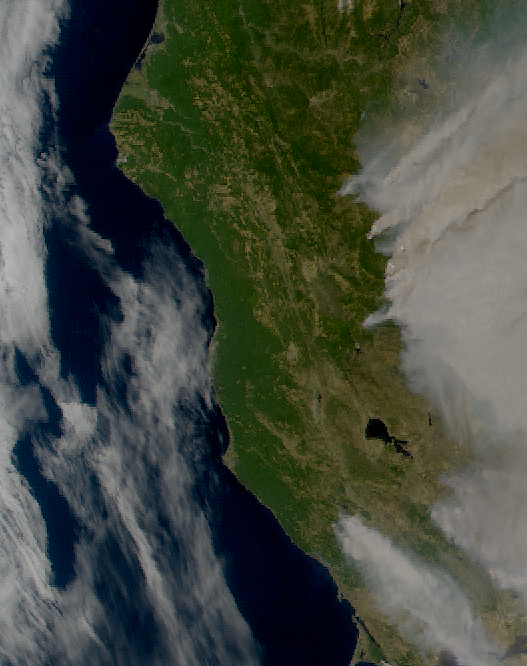

In [13]:
scn_resample.show('true_color')

## Create time-lapse animation of true colour composite imagery

Next, you can create a time-lapse animation of the true colour composite imagery using the satpy library. You begin by first defining the folder path to the base directory where the data files are stored.

In [14]:
folder_path = '../data/goes/17/level1b/2020/08/20/'

You can create a `MultiScene` object from all the files in the base directory, using the `abi_l1b` reader. 

In [15]:
from glob import glob
mscn = MultiScene.from_files(glob(os.path.join(folder_path, 'OR_*.nc')), reader='abi_l1b')

Then, you load the true colour composite for this `MultiScene` object using the `.load()` function.

In [16]:
mscn.load(['true_color'])

Finally you can resample the `MultiScene` object by the area definition you defined earlier which is stored in the variable `areadef`. 

In [17]:
new_mscn = mscn.resample(areadef)

If you want to save this animation, you can uncomment the following codeblock to save it as an `mpeg4` file.

In [18]:
# new_mscn.save_animation('{name}_{start_time:%Y%m%d_%H%M%S}.mp4', fps=5)

Now, we have saved and exported an animation video beforehand. You can view the video using the `Video` function from `iPython.display`.

In [ ]:
Video('./img/true_color_20200820_200117.mp4', width=500, height=500)

<center>
    <video controls width="70%">
        <source src="../_static/true_color_20200820_200117.mp4" type="video/mp4">
    </video>
</center>

### Create an animation with text

To add text to the video, you can use the [imageio-ffmpeg](https://github.com/imageio/imageio-ffmpeg) and the [pydecorate](https://pydecorate.readthedocs.io/en/latest/) libraries. Note that creating this video could take ten minutes or longer. To create and save the animation, you can remove the `"""` blockquotes from the following code block. 

You can reuse the resampled `MultiScene` object that you created earlier, which is stored in the variable `new_mscn`. 

First, set the file name of the `mpeg4` file. This is formatted as `text_{name:s}_{start_time:%Y%m%d_%H%M}.mp4`, which will result in a file name of `text_true_color_20200820_2001.mp4`

You can define the text that will appear in the video by changing the `txt` value. This is currently set as `California, USA {start_time:%Y-%m-%d %H:%M}` showing the location as well as the date and time that the image was recorded. 

You can align the text to one of the corners of the image by changing the values of `top_bottom` and `left_right`. We have aligned the text to appear on the top-left by setting the value of `top_bottom` to `"top"` and the value of `left_right` to `"left"`

You will need to also provide the file-path to a `.ttf` font file. We are using an open source font called `SourceSansPro-Bold`. 

The final parameters you can change are: 
- `font_size`: the size of the font
- `height`: the height of the text box
- `bg`: the background colour of the text box
- `bg_opacity`: the opacity of the text box
- `line`: the color of the line
- `fps`: the number of frames per second

In [ ]:
"""
new_mscn.save_animation(
    "text_{name:s}_{start_time:%Y%m%d_%H%M}.mp4",
    enh_args={
    "decorate": {
        "decorate": [
            {"text": {
                "txt": "California, USA {start_time:%Y-%m-%d %H:%M}",
                "align": {
                    "top_bottom": "top",
                    "left_right": "left"},
                "font": '../data/goes/17/level1b/2020/08/20/SourceSansPro-Bold.ttf',
                "font_size": 20,
                "height": 30,
                "bg": "black",
                "bg_opacity": 255,
                "line": "white"}}]}},
    fps=5
)
"""

Now, we have saved and exported an animation video with text beforehand. You can view the video using the `Video` function from `iPython.display`.

In [ ]:
Video('./img/text_true_color_20200820_2001.mp4', width=500, height=500)

<center>
    <video controls width="70%">
        <source src="../_static/text_true_color_20200820_2001.mp4" type="video/mp4">
    </video>
</center>

<hr>

### References
* GOES-R Calibration Working Group and GOES-R Series Program. (2017). <i>NOAA GOES-R Series Advanced Baseline Imager (ABI) Level 1b Radiances.</i> NOAA National Centers for Environmental Information. doi:10.7289/V5BV7DSR.

* Some code in this notebook was adapted from the following source:
    * origin: https://satpy.readthedocs.io/en/stable/multiscene.html#saving-frames-of-an-animation
    * copyright: 2009-2022, Pytroll developers
    * license: GPL-3.0 License
    * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Monitoring fires with next-generation satellites from MTG and Metop-SG: Californian Wildfires Case Study <br>
[](ca_part1_fig2)
```